In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='gruvboxd')
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')
jtplot.style(ticks=True, grid=False, figsize=(6.5, 5))

# TSVM

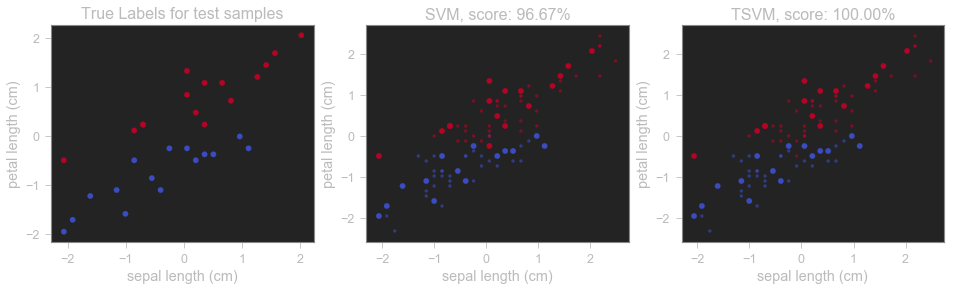

In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import sklearn.svm as svm
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# balanced data，each class has the same volume of every kind of data
iris = datasets.load_iris()
# data, label = iris.data[50:, [0, 3]], iris.target[50:] * 2 - 3  # 标签变为-1,1
data, label = iris.data[50:, :], iris.target[50:] * 2 - 3  # 4 attributes
# standardizing
sc = StandardScaler()
sc.fit(data)
data = sc.transform(data)

test_d, test_c = np.concatenate((data[:15], data[50:65])), np.concatenate((label[:15], label[50:65]))  # 30
l_d, l_c = np.concatenate((data[45:50], data[95:])), np.concatenate((label[45:50], label[95:]))  # 10
u_d = np.concatenate((data[15:45], data[65:95]))  # 60
lu_d = np.concatenate((l_d, u_d))
n = len(l_d)+len(u_d)
# u_d, u_c = np.concatenate((data[20:50], data[70:])), np.concatenate((label[20:50], label[70:]))  # 60

clf1 = svm.SVC(C=1,kernel='linear')
clf1.fit(l_d, l_c)
clf0 = svm.SVC(C=1,kernel='linear')
clf0.fit(l_d, l_c)
lu_c_0 = clf0.predict(lu_d) 

u_c_new = clf1.predict(u_d)  # the pseudo label for unlabelled samples
cu, cl = 0.001, 1
sample_weight = np.ones(n)
sample_weight[len(l_c):] = cu
id_set = np.arange(len(u_d))


while cu < cl:
    lu_c = np.concatenate((l_c, u_c_new))  # 70
    clf1.fit(lu_d, lu_c, sample_weight=sample_weight)
    while True:
        u_c_new = clf1.predict(u_d)  # the pseudo label for unlabelled samples
        u_dist = clf1.decision_function(u_d)  # the distance of each sample
        norm_weight = np.linalg.norm(clf1.coef_)  # norm of weight vector
        epsilon = 1 - u_dist * u_c_new * norm_weight

        plus_set, plus_id = epsilon[u_c_new > 0], id_set[u_c_new > 0]  # positive labelled samples
        minus_set, minus_id = epsilon[u_c_new < 0], id_set[u_c_new < 0]  # negative labelled samples
        plus_max_id, minus_max_id = plus_id[np.argmax(plus_set)], minus_id[np.argmax(minus_set)]
        a, b = epsilon[plus_max_id], epsilon[minus_max_id]

        if a > 0 and b > 0 and a + b > 2:
            u_c_new[plus_max_id], u_c_new[minus_max_id] = -u_c_new[plus_max_id], -u_c_new[minus_max_id]
            lu_c = np.concatenate((l_c, u_c_new))
            clf1.fit(lu_d, lu_c, sample_weight=sample_weight)
        else:
            break
    cu = min(cu * 2, cl)
    sample_weight[len(l_c):] = cu

lu_c = np.concatenate((l_c, u_c_new))
test_c1 = clf0.predict(test_d)
test_c2 = clf1.predict(test_d)
score1 = clf0.score(test_d,test_c)
score2 = clf1.score(test_d,test_c)

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(131)
ax.scatter(test_d[:,0],test_d[:,2],c=test_c,marker='o',cmap=plt.cm.coolwarm)
ax.set_title('True Labels for test samples',fontsize=16)
ax1 = fig.add_subplot(132)
ax1.scatter(test_d[:,0],test_d[:,2],c=test_c1,marker='o',cmap=plt.cm.coolwarm)
ax1.scatter(lu_d[:,0], lu_d[:,2], c=lu_c_0, marker='o',s=10,cmap=plt.cm.coolwarm,alpha=.6)
ax1.set_title('SVM, score: {0:.2f}%'.format(score1*100),fontsize=16)
ax2 = fig.add_subplot(133)
ax2.scatter(test_d[:,0],test_d[:,2],c=test_c2,marker='o',cmap=plt.cm.coolwarm)
ax2.scatter(lu_d[:,0], lu_d[:,2], c=lu_c, marker='o',s=10,cmap=plt.cm.coolwarm,alpha=.6)
ax2.set_title('TSVM, score: {0:.2f}%'.format(score2*100),fontsize=16)
for a in [ax,ax1,ax2]:
    a.set_xlabel(iris.feature_names[0])
    a.set_ylabel(iris.feature_names[2])
plt.show()

# S3VM

In [9]:
import copy as cp
import numpy as np
from scipy import optimize
from scipy import sparse
import time

class linear_k:

    def __init__(self, issparse):
        self._sparse = issparse

    def compute(self, data1, data2):
        if self._sparse:
            return data1 * data2.T
        else:
            return np.mat(data1) * np.mat(data2).T


class rbf_k:

    def __init__(self, sigma, issparse):
        self._sparse = issparse
        self._sigma = sigma

    def compute(self, mat1, mat2):
        mat1 = np.mat(mat1)
        mat2 = np.mat(mat2)
        mat1T_mat1 = np.mat([(v * v.T)[0, 0] for v in mat1]).T
        mat2T_mat2 = np.mat([(v * v.T)[0, 0] for v in mat2]).T
        mat1T_mat1 = mat1T_mat1 * np.mat(np.ones((mat2.shape[0], 1), dtype=np.float64)).T
        mat2T_mat2 = np.mat(np.ones((mat1.shape[0], 1), dtype=np.float64)) * mat2T_mat2.T
        k = mat1T_mat1 + mat2T_mat2
        k -= 2 * mat1 * mat2.T
        k *= - 1. / (2 * np.power(self._sigma, 2))
        return np.exp(k)

class Quasi_Newton_S3VM:

    def __init__(self, X_l, y, X_u, class_ratio=-1., lam=1., lam_u=1.,
                 sigma=1., kernel="linear", s=3., gamma=20.):
        print("initialization")
        self._start = time.time()
        self._X_l = X_l
        self._X_u = X_u
        self._y_T = np.mat(y, dtype=np.float64).T
        self._size_labeled = X_l.shape[0]
        self._size_unlabeled = X_u.shape[0]
        self._size_total = self._size_labeled + self._size_unlabeled
        self._lam = lam
        self._lam_u = lam_u
        self._sigma = sigma
        self._kernel = kernel
        self._gamma = gamma
        self._s = s
        if class_ratio == -1.:
            self._b = (1. / y.shape[0]) * np.sum(y)
        else:
            self._b = 2*class_ratio - 1
        self._numerically_stable_threshold = 500
        if sparse.issparse(self._X_l) and sparse.issparse(self._X_u):
            self._sparse = True
            self._X = sparse.vstack((X_l, X_u))
            self._X_u_mean = self._X_u.mean(axis=0)
            self._X_u_T = X_u.T
            self._X_l_T = X_l.T
            self._X_T = self._X.T
        else:
            print("computing kernel")
            self._sparse = False
            self._X = np.vstack((X_l, X_u))
            if self._kernel == "linear":
                self._kernel = linear_k(self._sparse)
            elif self._kernel == "rbf":
                self._kernel = rbf_k(self._sigma, self._sparse)
            self._K_l = self._kernel.compute(self._X_l, self._X)
            self._K_u = self._kernel.compute(self._X_u, self._X)
            if self._sparse:
                self._K_m_tmp = sparse.bmat([[self._K_l], [self._K_u]])
            else:
                self._K_m_tmp = np.bmat([[self._K_l], [self._K_u]])
            self._K_m = self._K_m_tmp
            self._center_kernel()

    def _center_kernel(self):
        print("centering kernel")
        self._K_X_X_u = self._kernel.compute(self._X, self._X_u)
        self._K_X_X_u_or_mean = (1. / self._size_unlabeled) * self._K_X_X_u.sum(axis=1)
        self._K_X_u_X = self._kernel.compute(self._X_u, self._X)
        self._K_X_u_X_ve_mean = (1. / self._size_unlabeled) * self._K_X_u_X.sum(axis=0)
        self._K_X_u_X_u = self._kernel.compute(self._X_u, self._X_u)
        self._K_X_u_X_u_mean = (1. / self._size_unlabeled ** 2) * self._K_X_u_X_u.sum()
        self._K_m_tmp = self._K_m_tmp - self._K_X_X_u_or_mean - \
                        self._K_X_u_X_ve_mean + self._K_X_u_X_u_mean
        self._K_m = self._K_m_tmp
        self._K_l = self._K_m_tmp[range(0, self._size_labeled), :]
        self._K_u = self._K_m_tmp[range(self._size_labeled, self._size_total), :]

    def fit(self):
        print("training started")
        self._annealing()

    def get_predictions(self, X, decision_function=False):
        print("predicting")
        if self._sparse:
            W = self._X.T * self._c - self._X_u_mean.T * np.sum(self._c)
            predictions = (X * W + self._b).T
        else:
            K_X_t_X = self._kernel.compute(X, self._X)
            K_X_t_X_u = self._kernel.compute(X, self._X_u)
            K_X_t_X_u_or_mean = (1.0 / self._size_unlabeled) * K_X_t_X_u.sum(axis=1)
            K_X_t_X = K_X_t_X - K_X_t_X_u_or_mean - self._K_X_u_X_ve_mean + self._K_X_u_X_u_mean
            predictions = (K_X_t_X * self._c + self._b).T
        if decision_function is True:
            return predictions.tolist()[0]
        else:
            return np.sign(predictions).tolist()[0]

    def get_train_time(self):
        return self._train_time

    def _annealing(self):
        c_current = np.zeros(self._size_total, dtype=np.float64)
        for i in [float(self._lam_u*i) for i in [.0, 0.000001, 0.0001, 0.01, 0.1, 0.5, 1.]]:
            print("annealing with lam_u =", i)
            self._lam_u = i
            c_current = self._bfgs(c_current)
        self._c = np.mat(c_current).T
        self._train_time = time.time() - self._start

    def _bfgs(self, c):
        if self._sparse:
            return optimize.fmin_l_bfgs_b(self._objective_function_sparse, c, m=50,
                                      fprime=self._objective_function_gradient_sparse, maxfun=500,
                                      factr=488288000, pgtol=1.0000000000000001e-05, iprint=0)[0]
        else:
            return optimize.fmin_l_bfgs_b(self._objective_function, c, m=50,
                                      fprime=self._objective_function_gradient, maxfun=500,
                                      factr=488288000, pgtol=1.0000000000000001e-05, iprint=0)[0]

    def _objective_function(self, c):
        #start = time.time()
        c = np.mat(c).T
        labeled_loss_tmp = self._gamma*(1. - np.multiply(self._y_T, self._K_l * c + self._b))
        labeled_loss_stable = cp.deepcopy(labeled_loss_tmp)
        mask = labeled_loss_tmp > 1./self._numerically_stable_threshold
        labeled_loss_stable[mask] = 0
        labeled_loss = np.log(1. + np.exp(labeled_loss_stable))
        np.place(labeled_loss, mask, np.array(labeled_loss_tmp[mask])[0])
        labeled_loss = (1./(self._gamma*self._size_labeled)) * np.sum(labeled_loss)
        unlabeled_loss = self._K_u * c + self._b
        unlabeled_loss = np.multiply(unlabeled_loss, unlabeled_loss)
        unlabeled_loss = (self._lam_u / self._size_unlabeled) * np.sum(np.exp(-self._s * unlabeled_loss))
        margin = self._lam * (c.T * self._K_m * c)
        #print("time for objective function", time.time() - start)
        return labeled_loss + unlabeled_loss + margin

    def _objective_function_gradient(self, c):
        #start = time.time()
        c = np.mat(c).T
        a_labeled_tmp = self._gamma * (1. - np.multiply(self._y_T, self._K_l * c + self._b))
        a_labeled_stable = cp.deepcopy(a_labeled_tmp)
        mask = a_labeled_tmp > 1./self._numerically_stable_threshold
        a_labeled_stable[mask] = 0
        a_labeled = np.exp(a_labeled_stable)
        a_labeled = np.multiply(a_labeled, 1./(1. + a_labeled))
        a_labeled[mask] = 1
        a_labeled = (-1./self._size_labeled) * np.multiply(self._y_T, a_labeled)
        k_a_labeled = a_labeled.T * self._K_l
        a_unlabeled_tmp = (self._K_u * c + self._b)
        a_unlabeled = np.multiply(a_unlabeled_tmp, a_unlabeled_tmp)
        a_unlabeled = np.exp(-self._s * a_unlabeled)
        a_unlabeled = (-2. * self._s * self._lam_u / self._size_unlabeled) \
                      * np.multiply(a_unlabeled, a_unlabeled_tmp)
        k_a_unlabeled = a_unlabeled.T * self._K_u
        margin = (2. * self._lam * (self._K_m * c)).T
        #print("time for objective function gradient", time.time() - start)
        return (k_a_labeled + k_a_unlabeled + margin).T

    def _objective_function_sparse(self, c):
        c = np.mat(c).T
        c_sum = np.sum(c)
        X_t_c = self._X_T*c - self._X_u_mean.T * c_sum
        labeled_loss_tmp = self._gamma*(1.0 - np.multiply(self._y_T,
                                                          (self._X_l * X_t_c - self._X_u_mean * X_t_c) + self._b))
        labeled_loss_stable = cp.deepcopy(labeled_loss_tmp)
        mask = labeled_loss_tmp > 1./self._numerically_stable_threshold
        labeled_loss_stable[mask] = 0
        labeled_loss = np.log(1. + np.exp(labeled_loss_stable))
        np.place(labeled_loss, mask, np.array(labeled_loss_tmp[mask])[0])
        labeled_loss = (1./(self._gamma*self._size_labeled)) * np.sum(labeled_loss)
        unlabeled_loss = (self._X_u * X_t_c - self._X_u_mean * X_t_c) + self._b
        unlabeled_loss = np.multiply(unlabeled_loss, unlabeled_loss)
        unlabeled_loss = (self._lam_u/self._size_unlabeled)*np.sum(np.exp(-self._s * unlabeled_loss))
        margin = self._lam * c.T * (self._X * X_t_c - self._X_u_mean * X_t_c)
        return labeled_loss + unlabeled_loss + margin

    def _objective_function_gradient_sparse(self, c):
        c = np.mat(c).T
        c_sum = np.sum(c)
        XTc = self._X_T * c - self._X_u_mean.T * c_sum
        a_labeled_tmp = self._gamma*(1.0 - np.multiply(self._y_T,
                                                       (self._X_l * XTc - self._X_u_mean * XTc) + self._b))
        a_labeled_stable = cp.deepcopy(a_labeled_tmp)
        mask = a_labeled_tmp > 1./self._numerically_stable_threshold
        a_labeled_stable[mask] = 0
        a_labeled = np.exp(a_labeled_stable)
        a_labeled = np.multiply(a_labeled, 1./(1. + a_labeled))
        a_labeled[mask] = 1
        a_labeled = np.multiply(self._y_T, a_labeled)
        a_labeled = self._X_l_T * a_labeled - self._X_u_mean.T * np.sum(a_labeled)
        K_a_labeled = (-1./self._size_labeled) * (self._X * a_labeled - self._X_u_mean * a_labeled)
        a_unlabeled_tmp = (self._X_u * XTc - self._X_u_mean * XTc) + self._b
        a_unlabeled = np.multiply(a_unlabeled_tmp, a_unlabeled_tmp)
        a_unlabeled = np.exp(-self._s * a_unlabeled)
        a_unlabeled = np.multiply(a_unlabeled, a_unlabeled_tmp)
        a_unlabeled = self._X_u_T * a_unlabeled - self._X_u_mean.T * np.sum(a_unlabeled)
        K_a_unlabeled = ((-2. * self._s * self._lam_u)/self._size_unlabeled) *\
                        (self._X * a_unlabeled - self._X_u_mean * a_unlabeled)
        margin = 2.*self._lam*(self._X * XTc - self._X_u_mean * XTc)
        return (K_a_labeled + K_a_unlabeled + margin).T

In [10]:
import pandas as pd
import numpy as np
train_xy = pd.read_csv("./another data/train_xy_clean.csv",index_col=["cust_group","cust_id"])
train_x_ul = pd.read_csv("./another data/train_x_clean.csv",index_col=["cust_group","cust_id"])
X = train_xy.drop("y",axis=1)
y = train_xy.y

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

train_x,test_x,train_y,test_y = train_test_split(X,y,stratify=y)
sfk = StratifiedKFold(n_splits=3,shuffle=True,random_state=111)

In [12]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'class_ratio':[-1.],
    'lam':[1.0],
    'lam_u':[1.],
    'sigma':[1.0],
    'kenel':['linear','rbf'],
    's':[3.],
    'gamma':[20.],
} 
S3VM = Quasi_Newton_S3VM(train_x,train_y,test_x,kernel='rbf')
# S3VM_grid = GridSearchCV(S3VM,param_grid,cv=sfk,scoring='roc_auc')
# S3VM_grid.best_estimator_

initialization
computing kernel
centering kernel


In [7]:
S3VM.fit()

training started
annealing with lam_u = 0.0
annealing with lam_u = 1e-06


ValueError: shapes (11138,14851) and (1,1) not aligned: 14851 (dim 1) != 1 (dim 0)

In [48]:
test_y_pred = S3VM.get_predictions(test_x)

predicting


In [52]:
pd.Series(test_y_pred).value_counts()
# test_y.value_counts()

 1.0    1916
-1.0    1797
dtype: int64